# NNIA 18/19 Project 2:  Gradient Descent & Backpropagation

In this exercise, you will implement a [multinomial logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) model with tensorflow for Fashion-MNIST dataset. Cross Validation will be used to find the best **regularization parameter** $\lambda$ for the L2-regularization term. Fashion-MNIST dataset is similar to the sklearn Digit dataset you used in the Project 1. It contains 60,000 training images and 10,000 testing images. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

![Neural Network](https://s3-eu-central-1.amazonaws.com/zalando-wp-zalando-research-production/2017/08/fashion-mnist-sprite.png)

Multinomial logistic regression is a probabilistic, linear classifier. It is parametrized by a weight matrix $W$ and a bias vector $b$. Classification is done by projecting an input vector onto a set of hyperplanes, each of which corresponds to a class. The distance from the input to a hyperplane reflects the probability that the input is a member of the corresponding class.

Mathematically, the probability that an input vector $\bf{x} \in \mathbb{R}^p$ is a member of a class $i$ can be written as:
$$P(Y=i|\textbf{x}, W, b) = softmax(W\textbf{x} + b)_i = \frac{e^{W_i\textbf{x} + b_i}}{\sum_j{e^{W_j\textbf{x} + b_j}}}$$
where $W \in \mathbb{R}^{c \times p}$, $b \in \mathbb{R}^c$ and $W_i \in \mathbb{R}^p$.

The model’s prediction $y_{pred}$ is the class whose probability is maximal, specifically:
$$y_{pred} = argmax_iP(Y=i|\textbf{x}, W, b)$$

We use cross-entropy loss with L2 regularization.

### 1.1 Dataset and Normalization

Load **Fashion-MNIST** dataset and normalized it.

In [4]:
import os
import struct
import numpy as np
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist
(X_trainval, Y_trainval), (X_test, Y_test) = fashion_mnist.load_data()

In [5]:
X_trainval = np.reshape(X_trainval, (X_trainval.shape[0],  X_trainval.shape[1] *  X_trainval.shape[2]))
print('The X_trainval has the following shape:')
print('Rows: %d, columns: %d' % (X_trainval.shape[0], X_trainval.shape[1]))

The X_trainval has the following shape:
Rows: 60000, columns: 784


In [6]:
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1] *  X_test.shape[2]))
print('The X_test has the following shape:')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

The X_test has the following shape:
Rows: 10000, columns: 784


Normalize the data. Subtract the mean and divide by the standard deviation.

In [7]:
def data_normalization(X_trainval, X_test):
    # TODO: Implement
    
    mean_X_trainval = np.mean(X_trainval, axis=0)  
    std_X_trainval = np.std(a=X_trainval, axis=0)
    mean_X_test  = np.mean(X_test, axis=0)  
    std_X_test = np.std(a=X_test, axis=0)
    X_trainval_normalized = np.divide(np.subtract(X_trainval, mean_X_trainval), std_X_trainval)
    X_test_normalized = np.divide(np.subtract(X_test, mean_X_test), std_X_test)
    return X_trainval_normalized, X_test_normalized

In [8]:
# The normalization should be done on X_train and X_test. 
# The normalized data should have the exactly same shape as the original data matrix.

X_trainval, X_test = data_normalization(X_trainval, X_test)
np.mean(X_trainval[:,0])

2.7237471537470508e-18

### 1.2 Define the Computation Graph

In [353]:
# Here the global configuration of this program is 
# defined, which you shouldn't change.

class global_config(object):
    lr = 0.0001  # learning rate
    img_h = 28  # image height
    img_w = 28  # image width
    num_class = 10  # number of classes
    num_epoch = 20  # number of training epochs
    batch_size = 16  # batch size
    K = 3  # K-fold cross validation
    num_train = None  # the number of training data
    lambd = None  # the factor for the L2-regularization

config = global_config()
config.num_train = X_trainval.shape[0];

In [354]:
def train_val_split(X_trainval, Y_trainval, i, K):
    """
    sklearn library is not allowed to use here.
    
    K is the total number of folds and i is the current fold.
    
    Think about how to deal with the case when the number of 
    training data can't be divided by K evenly.
    """
    #TODO: Implement
    train_indices = np.array([], dtype=int)
    fold_indices = CV_fold_indices(X=X_trainval, n_splits=K, shuffle=False, random_state=None)
    
    for idx, fold_idx in enumerate(fold_indices):
        if(idx==i):
            val_indices = fold_idx
        else:
            train_indices = np.append(train_indices, fold_idx)    
    
    X_val = X_trainval[val_indices]
    Y_val = Y_trainval[val_indices]
    X_train = X_trainval[train_indices]
    Y_train = Y_trainval[train_indices]
    
    #print("X_train, X_val, Y_train, Y_val", X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)
    
    return X_train, X_val, Y_train, Y_val

def CV_fold_indices(X, n_splits=3, shuffle=False, random_state=None):
    n_samples = X.shape[0] 
    #print("n_samples:", n_samples)
    indices = np.arange(n_samples)
    if shuffle:
        check_random_state(random_state).shuffle(indices)

    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
    fold_sizes[:n_samples % n_splits] += 1  # This is one way of dealing when number of samples cannot be divided by K evenly.
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        yield indices[start:stop]
        current = stop
        
def encode_labels(y, k):
    arr = np.zeros((len(y),k))
    for i in range(len(y)):
        arr[i][y[i]] = 1
    return arr

In [9]:
def shuffle_train_data(X_train, Y_train):
    """called after each epoch"""
    perm = np.random.permutation(len(Y_train))
    Xtr_shuf = X_train[perm]
    Ytr_shuf = Y_train[perm]
    return Xtr_shuf, Ytr_shuf

In [356]:
"""
training
"""
class logistic_regression(object):
    
    def __init__(self, X, Y_gt, config, name):
        """
        :param X: the training batch, which has the shape [batch_size, n_features].
        :param Y_gt: the corresponding ground truth label vector.
        :param config: the hyper-parameters you need for the implementation.
        :param name: the name of this logistic regression model which is used to
                     avoid the naming confict with the help of tf.variable_scope and reuse.
       
        Define the computation graph within the variable_scope here. 
        First define two variables W and b with tf.get_variable.
        Then do the forward pass.
        Then compute the cross entropy loss with tensorflow, don't forget the L2-regularization.
        The Adam optimizer is already given. You shouldn't change it.
        Finally compute the accuracy for one batch
        """
        self.config = config
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            #TODO: Define two variables and the forward pass.
            W = tf.get_variable("W", [config.num_class, (config.img_h*config.img_w)], initializer=tf.contrib.layers.xavier_initializer(seed=42))
            b = tf.get_variable("b", [config.num_class, 1], initializer=tf.zeros_initializer())
            
            # forward pass
            z1 = tf.add(tf.matmul(X,tf.transpose(W)), tf.transpose(b))
            
            #TODO: Compute the cross entropy loss with L2-regularization.
            self._loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=z1, labels=Y_gt)) + config.lambd*tf.nn.l2_loss(W)
            
            # Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent 
            # to update network weights iteratively.
            # It will be introduced in the lecture when talking about the optimization algorithms.
            self._train_step = tf.train.AdamOptimizer(config.lr).minimize(self._loss)
            #TODO: Compute the accuracy
            correct_prediction = tf.equal(tf.argmax(z1, axis=1), tf.argmax(Y_gt, axis=1))
            self._num_acc = tf.reduce_mean(tf.cast(correct_prediction, "float"))
                        
    @property
    def train_op(self):
        return self._train_step
    
    @property
    def loss(self):
        return self._loss
    
    @property
    def num_acc(self):
        return self._num_acc

In [357]:
def testing(model, X_test, Y_test, config):
    """ 
    Go through the X_test and use sess.run() to compute the loss and accuracy.
    
    Return the total loss and the accuracy for X_test.
    
    Note that this function will be used for the validation data
    during training and the test data after training.
    """
    num_test = X_test.shape[0]
    total_cost = 0
    accs = 0
    #TODO: Implement
    total_cost = sess.run(model.loss, feed_dict={X: X_test, Y_gt: Y_test})
    accs = sess.run(model.num_acc,feed_dict={X: X_test, Y_gt: Y_test})
    # Note: cost is already averaged over number samples in tensorflow function tf.reduce_mean, thus dividing by len(Y_test)
    # is not required.
    return total_cost, accs
    #return total_cost / len(Y_test), accs / len(Y_test) 

In [367]:
def train(model, X_train, X_val, Y_train, Y_val, config):
    """
    Train the model with sess.run().
    
    You should shuffle the data after each epoch and
    evaluate training and validation loss after each epoch.
    
    Return the lists of the training/validation loss and accuracy.
    """
    
    cost_trains = []
    acc_trains = []
    cost_vals = []
    acc_vals = []
        
    for i in range(config.num_epoch):
       #TODO: Implement
        cost_train = 0
        cost_val = 0
        acc_train = 0
        acc_val = 0
        num_minibatches = int(X_train.shape[0] // config.batch_size)
        Xtr_shuf, Ytr_shuf = shuffle_train_data(X_train, Y_train)
        Xval_shuf, Yval_shuf = shuffle_train_data(X_val, Y_val)
        for n_batch in range(num_minibatches):
            Xtr_batch = Xtr_shuf[n_batch*config.batch_size:min(((n_batch+1)*config.batch_size),len(X_train)),:]
            Ytr_batch = Ytr_shuf[n_batch*config.batch_size:min(((n_batch+1)*config.batch_size),len(X_train))]
            
            Ytr_enc_label = encode_labels(Ytr_batch, k=config.num_class)
            _, cost_train = sess.run([model.train_op, model.loss], feed_dict={X: Xtr_batch, Y_gt: Ytr_enc_label})
        cost_trains.append(cost_train)
        acc_train = sess.run(model.num_acc, feed_dict={X: Xtr_shuf, Y_gt: encode_labels(Ytr_shuf, k=config.num_class)})
        acc_trains.append(acc_train)
        print("Epoch: %d :" % (i + 1))
        print("Train Loss: %f" %  cost_train)
        print("Training acc: %f" % acc_train)
        
        cost_val, acc_val = testing(model=model, X_test=Xval_shuf, Y_test=encode_labels(Yval_shuf, k=config.num_class), config=config)
        cost_vals.append(cost_val)
        acc_vals.append(acc_val)
        print("Validation Loss: %f" % cost_val)
        print("Validation acc: %f" % acc_val)
    return cost_trains, acc_trains, cost_vals, acc_vals

### 1.3 Cross Validation

Implement cross validation to find an optimal value of $\lambda$. The optimal hyper-parameters should be determined by the validation accuracy. The test set should only be used in the very end after all other processing, e.g. hyper-parameter choosing.

In [359]:
"""
Initialization
"""
# Use cross validation to choose the best lambda for the L2-regularization from the list below
lambda_list = [100, 1, 0.1]

X = tf.placeholder(tf.float32, [None, config.img_h * config.img_w])
Y_gt = tf.placeholder(tf.int64, [None, config.num_class])

for lambd in lambda_list:
    val_loss_list = []
    config.lambd = lambd
    print("lambda is %f" % lambd)
    
    for i in range(config.K):
        # Prepare the training and validation data
        X_train, X_val, Y_train, Y_val = train_val_split(X_trainval, Y_trainval, i, config.K)
        
        # For each lambda and K, we build a new model and train it from scratch
        model = logistic_regression(X, Y_gt, config
                                    ,name=str(lambd)+'_'+str(config.K))
        
        with tf.Session() as sess:
            
            # Initialize the variables of the model
            sess.run(tf.global_variables_initializer())
            
            
            # Train the model
            cost_trains, acc_trains, cost_vals, acc_vals = train(model, X_train, X_val, Y_train, Y_val, config)
            
        val_loss_list.append(cost_vals[-1])
        
    print("The validation loss for lambda %f is %f" % (lambd, np.mean(val_loss_list)))

lambda is 100.000000
Epoch: 1 :
Train Loss: 2.272540
Training acc: 0.658725
Validation Loss: 2.191749
Validation acc: 0.653850
Epoch: 2 :
Train Loss: 2.313624
Training acc: 0.591175
Validation Loss: 2.194850
Validation acc: 0.587350
Epoch: 3 :
Train Loss: 2.221874
Training acc: 0.591750
Validation Loss: 2.203135
Validation acc: 0.589400
Epoch: 4 :
Train Loss: 2.227205
Training acc: 0.632400
Validation Loss: 2.203675
Validation acc: 0.629450
Epoch: 5 :
Train Loss: 2.190022
Training acc: 0.578075
Validation Loss: 2.207541
Validation acc: 0.575500
Epoch: 6 :
Train Loss: 2.253126
Training acc: 0.531350
Validation Loss: 2.205642
Validation acc: 0.527450
Epoch: 7 :
Train Loss: 2.191021
Training acc: 0.623575
Validation Loss: 2.199728
Validation acc: 0.618400
Epoch: 8 :
Train Loss: 2.233153
Training acc: 0.553950
Validation Loss: 2.199090
Validation acc: 0.551450
Epoch: 9 :
Train Loss: 2.184422
Training acc: 0.599100
Validation Loss: 2.202455
Validation acc: 0.597700
Epoch: 10 :
Train Loss: 2

Epoch: 18 :
Train Loss: 1.214007
Training acc: 0.778700
Validation Loss: 1.005943
Validation acc: 0.774500
Epoch: 19 :
Train Loss: 1.005856
Training acc: 0.777600
Validation Loss: 1.006707
Validation acc: 0.775550
Epoch: 20 :
Train Loss: 1.125405
Training acc: 0.780375
Validation Loss: 1.005095
Validation acc: 0.775950
Epoch: 1 :
Train Loss: 0.954855
Training acc: 0.767400
Validation Loss: 1.027739
Validation acc: 0.766450
Epoch: 2 :
Train Loss: 0.850413
Training acc: 0.775825
Validation Loss: 1.013795
Validation acc: 0.778000
Epoch: 3 :
Train Loss: 1.097554
Training acc: 0.772450
Validation Loss: 1.014519
Validation acc: 0.775650
Epoch: 4 :
Train Loss: 0.989608
Training acc: 0.772950
Validation Loss: 1.011914
Validation acc: 0.775100
Epoch: 5 :
Train Loss: 1.191717
Training acc: 0.773500
Validation Loss: 1.010062
Validation acc: 0.775700
Epoch: 6 :
Train Loss: 0.912674
Training acc: 0.777100
Validation Loss: 1.006704
Validation acc: 0.778450
Epoch: 7 :
Train Loss: 0.832242
Training ac

Epoch: 15 :
Train Loss: 0.646855
Training acc: 0.834750
Validation Loss: 0.625040
Validation acc: 0.835300
Epoch: 16 :
Train Loss: 0.432612
Training acc: 0.832625
Validation Loss: 0.626623
Validation acc: 0.833150
Epoch: 17 :
Train Loss: 0.779698
Training acc: 0.833475
Validation Loss: 0.625354
Validation acc: 0.835400
Epoch: 18 :
Train Loss: 0.673060
Training acc: 0.836000
Validation Loss: 0.625592
Validation acc: 0.836350
Epoch: 19 :
Train Loss: 0.554787
Training acc: 0.832075
Validation Loss: 0.629431
Validation acc: 0.833200
Epoch: 20 :
Train Loss: 0.420705
Training acc: 0.835775
Validation Loss: 0.625558
Validation acc: 0.836000
Epoch: 1 :
Train Loss: 1.281042
Training acc: 0.812000
Validation Loss: 0.967221
Validation acc: 0.807200
Epoch: 2 :
Train Loss: 0.793460
Training acc: 0.828175
Validation Loss: 0.720943
Validation acc: 0.822900
Epoch: 3 :
Train Loss: 0.459140
Training acc: 0.831300
Validation Loss: 0.658134
Validation acc: 0.826300
Epoch: 4 :
Train Loss: 0.894473
Training

### 1.4 Combine Train and Validation data.

Use the hyper-parameters you choose from the cross validation to re-train the model.

In [360]:
config.lambd =  0.1 #TODO: Choose the best lambda

model = logistic_regression(X, Y_gt, config, name='trainval')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_trains, acc_trains, cost_tests, acc_tests = train(model, X_trainval, X_test, Y_trainval, Y_test, config)

print("The final test acc is %f" % acc_tests[-1])

Epoch: 1 :
Train Loss: 0.791572
Training acc: 0.825567
Validation Loss: 0.824275
Validation acc: 0.815600
Epoch: 2 :
Train Loss: 0.543899
Training acc: 0.832467
Validation Loss: 0.681321
Validation acc: 0.820200
Epoch: 3 :
Train Loss: 0.415380
Training acc: 0.834017
Validation Loss: 0.658659
Validation acc: 0.819600
Epoch: 4 :
Train Loss: 0.575336
Training acc: 0.836383
Validation Loss: 0.648015
Validation acc: 0.823300
Epoch: 5 :
Train Loss: 0.617436
Training acc: 0.832967
Validation Loss: 0.651748
Validation acc: 0.818900
Epoch: 6 :
Train Loss: 0.853357
Training acc: 0.833817
Validation Loss: 0.648201
Validation acc: 0.822400
Epoch: 7 :
Train Loss: 0.537748
Training acc: 0.835217
Validation Loss: 0.647944
Validation acc: 0.821200
Epoch: 8 :
Train Loss: 0.560548
Training acc: 0.833950
Validation Loss: 0.647417
Validation acc: 0.821900
Epoch: 9 :
Train Loss: 0.513177
Training acc: 0.832667
Validation Loss: 0.647321
Validation acc: 0.821200
Epoch: 10 :
Train Loss: 1.141453
Training acc:

In [13]:
import numpy as np
from scipy.special import expit

costs_list_all = []

class Fully_connected_Neural_Network(object):
    """ Fully-connected neural network with one hidden layer.
    
    Parameters
    ------------
    n_output : int
        Number of class labels.
        
    n_features : int
        Number of input features.
        
    n_hidden : int
        Number of hidden units.
        
    l2 : float
        regularization parameter
        0 means no regularization
        
    epochs : int
        One Epoch is when the entire dataset is passed forward and backward through the neural network only once.
        
    lr : float
        Learning rate.
        
    batchsize : int
        Total number of training examples present in a single batch.
        

    Attributes
    -----------
    w1 : array, shape = [n_features, n_hidden_units]
        Weight matrix for input layer -> hidden layer.
    w2 : array, shape = [n_hidden_units, n_output_units]
        Weight matrix for hidden layer -> output layer.
    b1 : array, shape = [n_hidden_units, ]
        Bias for input layer-> hidden layer.
    b2 : array, shape = [n_output_units, ]
        Bias for hidden layer -> output layer.
    """
    def __init__(self, n_output, n_features, n_hidden=30,
                 l2=0.0, epochs=50, lr=0.001,
                 batchsize=1):
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.lr = lr
        self.batchsize = batchsize
        self.cost_ = []
        #TODO Initialize weights and biases with np.random.uniform or np.random.normal and specify the shape
        # Note: self.weights1 contains W1 and b1; self.weights2 contains W2 and b2. see function initilize_weights() for more details.
        self.weights1, self.weights2 = self.initialize_weights()
        print("weights1.shape", self.weights1.shape)
        print("weights2.shape", self.weights2.shape)
        self.w1 = self.weights1[:,0:783]
        self.b1 = self.weights1[:,784]
        self.w2 = self.weights2[:,0:49]
        self.b2 = self.weights1[:,50]
        
    def sigmoid(self, z):
        """Compute sigmoid function"""
        #TODO Implement
        #return (1+1/np.exp(-z))
        return expit(z)
    
    def sigmoid_gradient(self, z):
        """Compute gradient of the sigmoid function"""
        #TODO Implement
        return (self.sigmoid(z) * (1 - self.sigmoid(z)))
        
    def softmax(self, z):
        """Compute softmax function.
        Implement a stable version which 
        takes care of overflow and underflow.
        """  
        m = np.amax(z,axis=1)
        m = m[:,np.newaxis]
        sums = np.sum(np.exp(z - m),axis=1)
        sums = sums[:,np.newaxis]
        return (np.exp(z - m) / sums)

    

    def forward(self, X, w1, w2):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            
        Returns
        ----------
        z2 : array,
            Input of the hidden layer.
        a2 : array,
            Output of the hidden layer.
        z3 : array,
            Input of the output layer.
        a3 : array,
            Output of the output layer.

        """
        
        # TODO Implement
        a1 = self.add_bias_unit(X)
        z2 = np.matmul(a1, w1.transpose())
        a2 = self.sigmoid(z2)
        a2_bias = self.add_bias_unit(a2)
        z3 = np.matmul(a2_bias, w2.transpose())
        a3 = self.softmax(z3)
        return a1,z2,a2_bias,z3,a3

    def L2_regularization(self, lambd, w1, w2):
        """Compute L2-regularization cost"""
        #TODO Implement
        return (lambd/2.0)*(np.sum(w1**2) + np.sum(w2**2))

        
    def loss(self, y_enc, output, w1, w2, epsilon=1e-12):
        """Implement the cross-entropy loss.

        Parameters
        ----------
        y_enc : array, one-hot encoded labels.
        
        output : array, output of the output layer
        
        epsilon: used to turn log(0) into log(epsilon)

        Returns
        ---------
        cost : float, total loss.

        """
        
        #TODO Implement
        regularizer_cost = 0
        regularizer_cost += self.L2_regularization(self.l2, w1, w2)
        pred_cost = - np.sum((y_enc * np.log(output+epsilon)) + ((1 - y_enc+epsilon) * np.log(1 - output)))
        cost = pred_cost + regularizer_cost
        return cost/y_enc.shape[0]

    def compute_gradient(self, a1, a2, a3, z2, z3, y_enc, w1, w2):
        """ Compute gradient using backpropagation.

        Parameters
        ------------
        X  : array, Input.
        a2 : array, output of the hidden layer.
        a3 : array, output of the output layer.
        z2 : array, input of the hidden layer.
        y_enc : array, one-hot encoded labels.

        Returns
        ---------
        grad_1 : array, Gradient of the weight matrix w1.
        grad_2 : array, Gradient of the weight matrix w2.
        grad_3 : array, Gradient of the bias vector b1.
        grad_4 : array, Gradient of the bias vector b2.
        """
        
        #TODO Implement
        #del3 = self.sigmoid_gradient(z3) * (-y_enc+ a3)
        #del3 = self.softmax_gradient(z3) * (a3 - y_enc)
        del3 = (a3 - y_enc)
        grad_2 = np.dot(del3.T, a2)
        z2 = self.add_bias_unit(z2)
        del2 = self.sigmoid_gradient(z2) * np.dot(del3, w2)
        del2 = del2[:,1:]
        grad_1 = np.dot(del2.T, a1)
        
        # Adding gradinet of regularizer terms
        grad_2 += self.l2 * w2
        grad_1 += self.l2 * w1
        grad_3, grad_4 = grad_1[:,784], grad_2[0:50]
        return grad_1,grad_2,grad_3, grad_4

    def inference(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, Input layer with original features.

        Returns:
        ----------
        y_pred : array, Predicted class labels.

        """
        
        # TODO Implement
        a1,z2,a2,z3,a3 = self.forward(X, self.weights1, self.weights2)
        return np.argmax(a3, axis=1)
    
    def shuffle_train_data(self, X, Y):
        """called after each epoch"""
        perm = np.random.permutation(Y.shape[0])
        X_shuf = X[perm]
        Y_shuf = Y[perm]
        return X_shuf, Y_shuf
        
    def train(self, X, y, verbose=False):
        """ Fit the model.

        Parameters
        -----------
        X : array, Input.
        y : array, Ground truth class labels.
        verbose : bool, Print the training progress

        Returns:
        ----------
        self

        """
        #TODO Initialization
        self.cost_ = []
        
        learning_rate = self.lr
        num_batches = self.batchsize
        batch_size = len(X_trainval) // num_batches
        for epoch in range(self.epochs):
            train_X, train_Y = self.shuffle_train_data(X_trainval,Y_trainval)            
            for b in range(num_batches):
                x_batch = train_X[b*batch_size:min(((b+1)*batch_size),len(X_trainval)),:]
                y_batch = train_Y[b*batch_size:min(((b+1)*batch_size),len(X_trainval))]
                y_enc = self.encode_labels(y_batch,self.n_output)
                a1,z2,a2,z3,a3 = self.forward(x_batch,self.weights1,self.weights2)
                # Calculate loss
                cost = self.loss(y_enc, a3, self.weights1, self.weights2)
                # Do backprop
                grad1, grad2, grad_3, grad_4 = self.compute_gradient(a1, a2, a3, z2, z3, y_enc, self.weights1, self.weights2)
                # Do one step of gradient descent using the gradients
                self.weights1 -= learning_rate * grad1
                self.weights2 -= learning_rate * grad2
                self.w1 -= learning_rate * self.weights1[:,0:783]
                self.b1 -= learning_rate * self.weights1[:,784]
                self.w2 -= learning_rate * self.weights2[:,0:49]
                self.b2 -= learning_rate * self.weights1[:,50]
                # Store cost for the first plotting problem
                costs_list_all.append(cost)
                
            # Update cost_ list after each epoch
            y_enc_train = self.encode_labels(Y_trainval,self.n_output)
            a1_train,z2_train,a2_train,z3_train,a3_train = self.forward(X_trainval,self.weights1,self.weights2)
            cost_train = self.loss(y_enc_train, a3_train, self.weights1, self.weights2)
            self.cost_.append(cost_train)
            
            if (verbose) and ((epoch % 10) == 0 or epoch == self.epochs - 1):
                print ("Epoch:",epoch,"Cost:",self.cost_[-1])

    # Additional functions defined for convenient implementation
    def encode_labels(self, y, k):
        arr = np.zeros((len(y),k))
        for i in range(len(y)):
            arr[i][y[i]] = 1
        return arr

    def initialize_weights(self):
        rand = np.random.RandomState(seed=1)
        weights1 = rand.normal(size=(self.n_hidden,self.n_features+1)) * 0.0001
        weights2 = rand.normal(size=(self.n_output,self.n_hidden+1)) * 0.0001
        return weights1, weights2
    
    def softmax_gradient(self, z):
        I = np.eye(z.shape[0],z.shape[1])
        return self.softmax(z) * (I - self.softmax(z))

    def add_bias_unit(self, X):
        if len(X.shape) > 1:
            le = X.shape[0]
            b = np.ones((le,1))
        else:
            l = 1
            b = np.ones(l)
        X = np.concatenate((b,X),axis=1)
        return X

In [14]:
nn = Fully_connected_Neural_Network(n_output=10, 
                                    n_features=X_trainval.shape[1], 
                                    n_hidden=50, 
                                    l2=0.1, 
                                    epochs=1000, 
                                    lr=0.001,
                                    batchsize=50)

weights1.shape (50, 785)
weights2.shape (10, 51)


In [15]:
nn.train(X_trainval, Y_trainval, verbose=True)

Epoch: 0 Cost: 2.5366724129074716
Epoch: 10 Cost: 0.8524639858034313
Epoch: 20 Cost: 0.7162574689471092
Epoch: 30 Cost: 0.6629876871936073
Epoch: 40 Cost: 0.6290721187927946
Epoch: 50 Cost: 0.6044998592911964
Epoch: 60 Cost: 0.5842223041883026
Epoch: 70 Cost: 0.5692228582299659
Epoch: 80 Cost: 0.5555164552913749
Epoch: 90 Cost: 0.5449187331024774
Epoch: 100 Cost: 0.5339346010189218
Epoch: 110 Cost: 0.5254499946318855
Epoch: 120 Cost: 0.517040160705805
Epoch: 130 Cost: 0.5105147454912969
Epoch: 140 Cost: 0.5014044258433893
Epoch: 150 Cost: 0.49562279181715674
Epoch: 160 Cost: 0.48952832237159566
Epoch: 170 Cost: 0.48694123905582054
Epoch: 180 Cost: 0.4783409525963082
Epoch: 190 Cost: 0.474636228876948
Epoch: 200 Cost: 0.46980712969445243
Epoch: 210 Cost: 0.4685452609455232
Epoch: 220 Cost: 0.46426283587024025
Epoch: 230 Cost: 0.4599284004855235
Epoch: 240 Cost: 0.45524427743828016
Epoch: 250 Cost: 0.4521984355432891
Epoch: 260 Cost: 0.4482619503901943
Epoch: 270 Cost: 0.4453491682049519

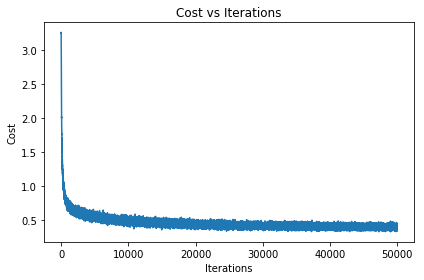

In [19]:
import matplotlib.pyplot as plt

# Plot the training error for every iteration
# in every epoch

# TODO Implement
#print (len(nn.cost_))
plt.plot(range(0,len(costs_list_all)),costs_list_all)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs Iterations')
plt.tight_layout()
plt.show()

1000


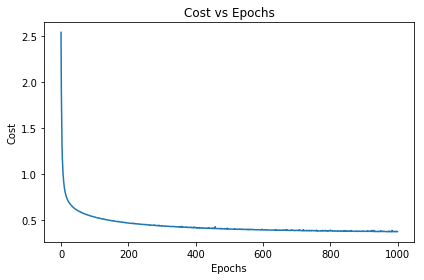

In [17]:
# Plot the training error in every epoch
# TODO Implement
print (len(nn.cost_))
plt.plot(range(0,len(nn.cost_)), nn.cost_)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.title('Cost vs Epochs')
plt.tight_layout()
plt.show()

In [18]:
# Compute Training Accuracy
# TODO Implement
pred_labels_training = nn.inference(X_trainval)
acc = 0
print (pred_labels_training)
print (Y_trainval)
for index,val in np.ndenumerate(pred_labels_training):
    if pred_labels_training[index] == Y_trainval[index]:
        acc += 1
acc /= Y_trainval.shape[0]
print('Training accuracy: %.2f%%' % (acc * 100))

# Compute Test Accuracy
# TODO Implement
pred_labels_test = nn.inference(X_test)
acc = 0
print (pred_labels_test)
print (Y_test)
for index,val in np.ndenumerate(pred_labels_test):
    if pred_labels_test[index] == Y_test[index]:
        acc += 1
acc /= Y_test.shape[0]
print('Test accuracy: %.2f%%' % (acc * 100))

[9 0 0 ... 3 0 5]
[9 0 0 ... 3 0 5]
Training accuracy: 94.65%
[9 2 1 ... 8 1 5]
[9 2 1 ... 8 1 5]
Test accuracy: 88.39%
